In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [2]:
roi_file_paths = {
                'roi_1':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/segmentations/nuclei_20240604_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_1/exports'
                           },
                'roi_2':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/segmentations/nuclei_20240529_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_2/exports'
                           },
                'roi_3':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/segmentations/nuclei_20240604_nuclei.tiff',
                           'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/exports/decode_20240604.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/projects/roi_3/exports'
                           },
                'timezero_roi_1':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/segmentations/segmentation_20240513_nuclei.tiff',
                              # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                              'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/transcripts/20240517_segmentation_withRefid.csv',
                              'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/exports'
                              },
                  'timezero_roi_2':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/segmentations/segment_091924_nuclei.tiff',
                            # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                            'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/transcripts/transcripts.csv',
                            'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi2/exports'
                            },
                    'timezero_roi_3':{'segmentation_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/segmentations/segment_20240921_nuclei.tiff',
                              # 'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi1/genes/matrix_20240517_segmentation_segmentation_20240513_cells.csv',
                              'spots_file':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/transcripts/transcripts.csv',
                              'out_path':'/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-04-27_spatialbarcodes_SG_expression_mouse_exp/time_zero_output/roi3/exports'
                              },
                'run2_roi_2':{'segmentation_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/segmentation.tiff',
                            'spots_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/transcripts.csv',
                            'out_path':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_2/exports/',
                            },
                'run2_roi_3':{'segmentation_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/segmentation.tiff',
                            'spots_file':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/transcripts.csv',
                            'out_path':'/Volumes/GRK_003/2024-08-08_spatialbarcode_tumor2_projects/roi_3/exports/',
                            },
                  
                  }

In [3]:
## load data for the roi of interest    
roi_of_interest = 'roi_2'

# load the sg_object
with open(f'{roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')



In [123]:
image_path = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/rawData/roi_2/hyb_1_aligned.tiff'

In [124]:
tiff_image = io.imread(image_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-05-21_mouseexp_expression/rawData/roi_2/hyb_1_aligned.tiff'

In [4]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [5]:
df['cell_id'] = [str(id) for id in df['object_id']]

# sg_obj.gdf['cell_id'] = [str(x) for x in sg_obj.gdf['object_id']]
sg_obj.gdf['object_id'] = sg_obj.gdf.index
sg_obj.gdf['cell_id'] = sg_obj.gdf['object_id'].astype('string')
sg_obj.gdf.index.name = 'index'
sg_obj.gdf = sg_obj.gdf.sort_values('object_id')

# assign clusters to the sg_obj
sg_obj.gdf = sg_obj.gdf.merge(df[['cell_id']+list(df.columns.difference(sg_obj.gdf.columns))],on=['cell_id'],how='left')

In [26]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','object_id','area','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    

adata_genes = sc.AnnData(df[gene_cols])

obs_cols= ['cell_id','n_called_barcodes','barcode_names','called_barcodes'] + cols_to_keep 

adata_genes.obs = df[obs_cols]

adata_genes.obs.index = adata_genes.obs.index.astype(str)

/var/folders/9y/6d7h4kvn6f989_h_gypc_j_00000gn/T/ipykernel_53537/2172998446.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_genes = sc.AnnData(df[gene_cols])
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/grantkinsler/miniforge3/envs/spatialgenomics-env2/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [21]:
## LOAD MANUAL ANNOTATION FILE

manual_annotation = pd.read_csv('cluster 31 manual annotation - manual_annotation_radius_large.csv')

manual_annotation= manual_annotation[manual_annotation['object_id'].notnull()]
# manual_annotation['object_id'] = manual_annotation['object_id'].astype('str')


In [22]:
manual_cluster = manual_annotation[((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['POSSIBLE','TRUE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['TRUE']))) |

                   ((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['TRUE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['POSSIBLE','TRUE']))) | 
                   
                   ((manual_annotation['FIRST_PASS_CONTAINS_BARCODES'].isin(['POSSIBLE']) & 
                   manual_annotation['SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES'].isin(['POSSIBLE']))) 

                   ] 
                   

In [23]:
manual_cluster

,object_id,FIRST_PASS_CONTAINS_BARCODES,First pass notes,SECOND_PASS_CONTAINS_NO_EXTRA_BARCODES,second pass notes,bc_cluster,bc_cluster_bc_names,called_barcodes,bc_016,bc_040,bc_052,bc_092,bc_093,cluster_bc_count,nonzero_cluster_bc_count
0,28140,TRUE,NaN,TRUE,NaN,31.0,bc_016-bc_040-bc_052-bc_092-bc_093,"['bc_052', 'bc_092', 'bc_093']",2.0,2.0,3.0,3.0,6.0,16.0,5.0
1,28279,TRUE,NaN,TRUE,SMALL CONTAMINATION,31.0,bc_016-bc_040-bc_052-bc_092-bc_093,"['bc_024', 'bc_040', 'bc_052', 'bc_092', 'bc_0...",1.0,3.0,5.0,8.0,3.0,20.0,5.0
2,28729,TRUE,NaN,TRUE,NaN,31.0,bc_016-bc_040-bc_052-bc_092-bc_093,"['bc_016', 'bc_040', 'bc_052', 'bc_092', 'bc_0...",6.0,7.0,6.0,10.0,12.0,41.0,5.0
5,30006,TRUE,NaN,TRUE,NaN,2630.0,bc_009-bc_092-bc_093,"['bc_009', 'bc_092', 'bc_093']",0.0,1.0,0.0,6.0,5.0,12.0,3.0
9,30256,TRUE,NaN,TRUE,SMALL CONTAMINATION,31.0,bc_016-bc_040-bc_052-bc_092-bc_093,"['bc_040', 'bc_052', 'bc_092', 'bc_093']",2.0,9.0,11.0,8.0,5.0,35.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,34772,TRUE,NaN,TRUE,NaN,31.0,bc_016-bc_040-bc_052-bc_092-bc_093,"['bc_040', 'bc_052', 'bc_092', 'bc_093']",0.0,6.0,3.0,3.0,6.0,18.0,4.0
174,34872,TRUE,NaN,POSSIBLE,LIKELY TRUE,1096.0,bc_004-bc_040-bc_041-bc_048-bc_052-bc_092-bc_093,"['bc_001', 'bc_004', 'bc_016', 'bc_040', 'bc_0...",4.0,16.0,23.0,12.0,24.0,79.0,5.0
177,35566,POSSIBLE,MISSING SOME,POSSIBLE,POSSIBLE EXTRA,612.0,bc_024-bc_040-bc_092,"['bc_004', 'bc_024', 'bc_040', 'bc_041', 'bc_0...",0.0,13.0,2.0,11.0,1.0,27.0,4.0
180,36023,TRUE,NaN,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
merged_gdf = sg_obj.gdf

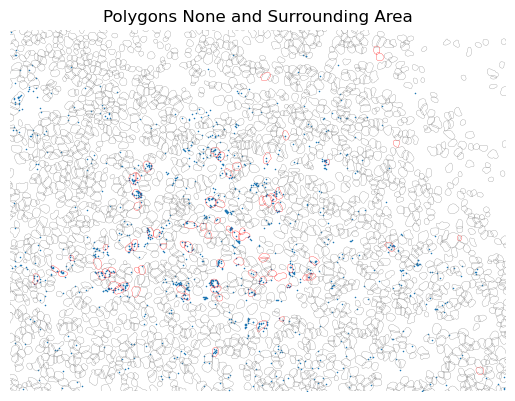

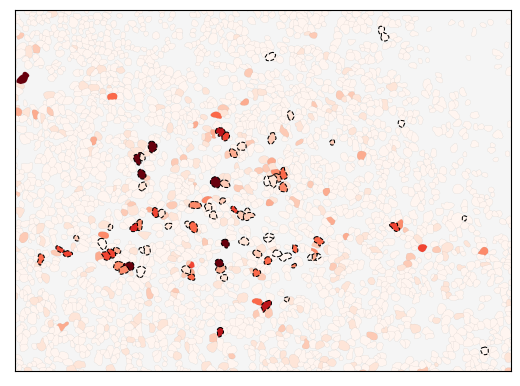

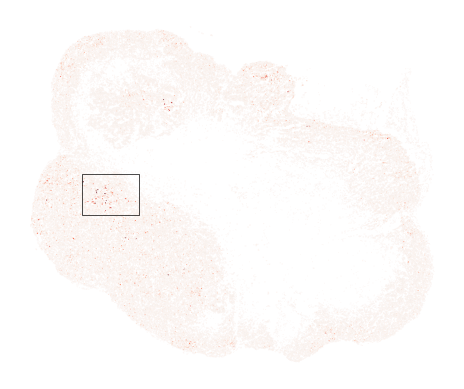

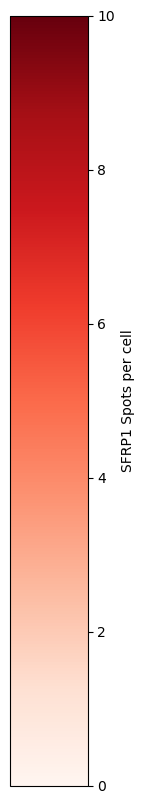

In [30]:
# gene_of_interest = 'VCAM1'
gene_of_interest = 'SFRP1'
# gene_of_interest = 'SPARC'
# gene_of_interest = 'SFRP1'
# gene_of_interest = 'FN1'
# gene_of_interest = 'BGN'
cluster_of_interest = 31

# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)

cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)

central_ix = int(len(cluster_cells)/2)

cell_id = cluster_cells[central_ix]

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

# sg_obj.gdf['object_id'] = sg_obj.gdf.index
# sg_obj.gdf['cell_id'] = sg_obj.gdf['cell_id'].astype('string')


gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')


fig,ax = plt.subplots()
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SFRP1'],central_polygon_ix=central_ix,
                            color_map={'SFRP1':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                            #    id_field='cell_id',
                            annotate=False,image_scale=0.1,
                            focal_outline_color='r',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.2,
                            exterior_marker='.',marker_size=5,ax=ax)

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

plt.axis('off')
# plt.title()
plt.gca().invert_yaxis()

### PLOT THE ZOOMED IN IMAGE     
fig,ax = plt.subplots()

vmin = 0
vmax = 10

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

bbox = box(xmin,ymin,xmax,ymax)

other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

# other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

# print(merged_gdf_focal.shape)

merged_gdf_other.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

# this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='k',linewidth=0.75,linestyle='--')

# rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
# ax.add_patch(rect)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()

ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('#F5F5F5')

plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_zoom.pdf',bbox_inches='tight')


### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
fig,ax = plt.subplots()

# ax = fig.add_subplot(223)

merged_gdf.plot(column=gene_of_interest, cmap='Reds', legend=False,vmin=vmin,vmax=vmax,ax=ax,
                edgecolor='#d9d9d9',linewidth=0.01)


# ax.set_facecolor('k')
rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

# ax.set_facecolor('#F5F5F5')
# ax.set_xticks([])
# ax.set_yticks([])
plt.axis('off')
plt.gca().invert_yaxis()

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_full.pdf',bbox_inches='tight')


### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(1,10))
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')



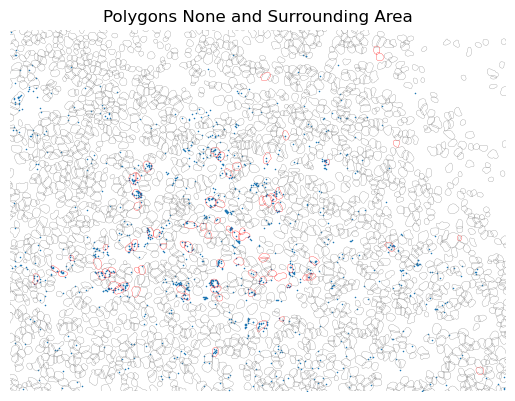

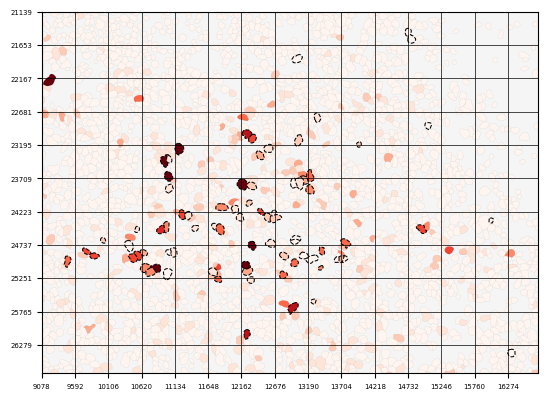

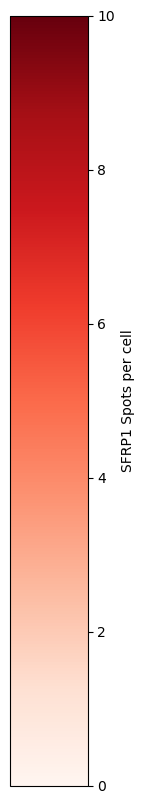

In [ ]:
# gene_of_interest = 'VCAM1'
gene_of_interest = 'SFRP1'
# gene_of_interest = 'SPARC'
# gene_of_interest = 'SFRP1'
# gene_of_interest = 'FN1'
# gene_of_interest = 'BGN'
cluster_of_interest = 31

# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)

cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)

central_ix = int(len(cluster_cells)/2)

cell_id = cluster_cells[central_ix]

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

# sg_obj.gdf['object_id'] = sg_obj.gdf.index
# sg_obj.gdf['cell_id'] = sg_obj.gdf['cell_id'].astype('string')


gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')


fig,ax = plt.subplots()
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SFRP1'],central_polygon_ix=central_ix,
                            color_map={'SFRP1':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                            #    id_field='cell_id',
                            annotate=False,image_scale=0.1,
                            focal_outline_color='r',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.2,
                            exterior_marker='.',marker_size=5,ax=ax)

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

plt.axis('off')
# plt.title()
plt.gca().invert_yaxis()

### PLOT THE ZOOMED IN IMAGE     
fig,ax = plt.subplots()

vmin = 0
vmax = 10

bbox = box(xmin,ymin,xmax,ymax)

other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

# other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

# print(merged_gdf_focal.shape)

merged_gdf_other.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

# this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='k',linewidth=0.75,linestyle='--')

# rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
# ax.add_patch(rect)

# ax.set_xticks([])
# ax.set_yticks([])
ax.set_facecolor('#F5F5F5')

# visium HD has 2 micron grid size. This is roughly every 2000/107 = 18.7 pixels
# plt.gca().set_xticks([xmin+18.7*i for i in range(int((xmax-xmin)/18.7)+1)])
# plt.gca().set_yticks([ymin+18.7*i for i in range(int((ymax-ymin)/18.7)+1)])
# plt.gca().tick_params(which='major', color='k')
# plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.1)

# visium HD has 8 micron grid size as starting point. This is roughly every 8000/107 =74.77 pixels
# plt.gca().set_xticks([xmin+74.77*i for i in range(int((xmax-xmin)/74.77)+1)])
# plt.gca().set_yticks([ymin+74.77*i for i in range(int((ymax-ymin)/74.77)+1)])
# plt.gca().tick_params(which='major', color='k')
# plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.1)

# visium has 55 micron grid size. This is roughly every 55000/107 = 514 pixels
plt.gca().set_xticks([xmin+514*i for i in range(int((xmax-xmin)/514)+1)])
plt.gca().set_yticks([ymin+514*i for i in range(int((ymax-ymin)/514)+1)])
plt.gca().tick_params(which='major', color='k')
plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.5)

# plt.gca().xaxis.set_ticklabels([])
# plt.gca().yaxis.set_ticklabels([])

ax.tick_params(axis='both', which='major', labelsize=5)
ax.tick_params(axis='both', which='minor', labelsize=2)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()


# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_zoom_VisiumHD8umGrid.pdf',bbox_inches='tight')


# ### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
# fig,ax = plt.subplots()

# # ax = fig.add_subplot(223)

# merged_gdf.plot(column=gene_of_interest, cmap='Reds', legend=False,vmin=vmin,vmax=vmax,ax=ax,
#                 edgecolor='#d9d9d9',linewidth=0.01)


# # ax.set_facecolor('k')
# rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
# # Add the patch to the Axes
# ax.add_patch(rect)

# # ax.set_facecolor('#F5F5F5')
# # ax.set_xticks([])
# # ax.set_yticks([])
# plt.axis('off')
# plt.gca().invert_yaxis()

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_full.pdf',bbox_inches='tight')


### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(1,10))
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')



In [36]:
sg_obj.points_gdf.head()

,name,refid,x,y,geometry
0,SOX10,ENSG00000100146,18203,53,POINT (18203.000 53.000)
1,SOX10,ENSG00000100146,18260,132,POINT (18260.000 132.000)
2,SOX10,ENSG00000100146,18185,77,POINT (18185.000 77.000)
3,SOX10,ENSG00000100146,18434,223,POINT (18434.000 223.000)
4,SOX10,ENSG00000100146,22740,204,POINT (22740.000 204.000)


In [ ]:
# visium has 55 micron grid size. This is roughly every 55000/107 = 514 pixels
# plt.gca().set_xticks([xmin+514*i for i in range(int((xmax-xmin)/514)+1)])
# plt.gca().set_yticks([ymin+514*i for i in range(int((ymax-ymin)/514)+1)])
# plt.gca().tick_params(which='major', color='k')
# plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.5)

Text(0.5, 1.0, 'SFRP1 spots')

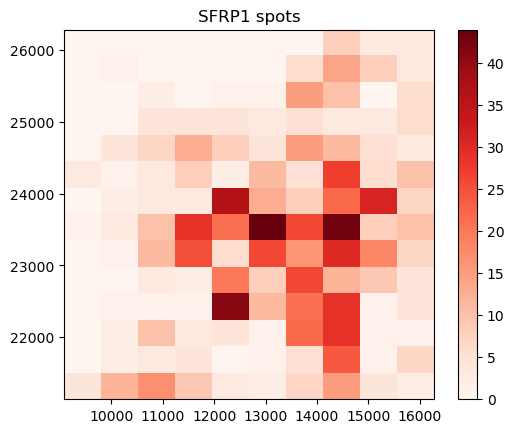

In [ ]:
points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name']=='SFRP1']

H, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+514*i for i in range(int((xmax-xmin)/514)+1)],
                                                                   [ymin+514*i for i in range(int((ymax-ymin)/514)+1)]])

# Plot the 2D histogram
plt.imshow(H, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Reds')
plt.colorbar()
# plt.gca().set_aspect('equal')
plt.gca().set_aspect(abs((xedges[-1]-xedges[0])/(yedges[0]-yedges[-1]))*1)
plt.gca().invert_yaxis()
plt.title('SFRP1 spots')
# plt.show()

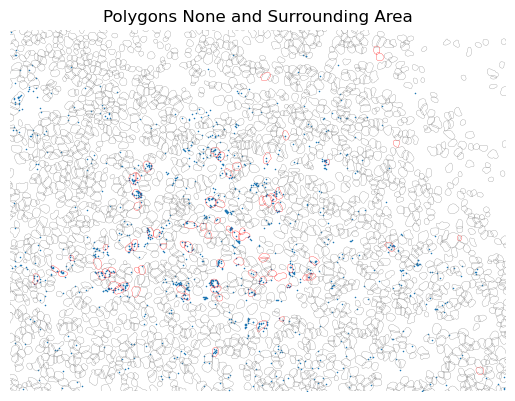

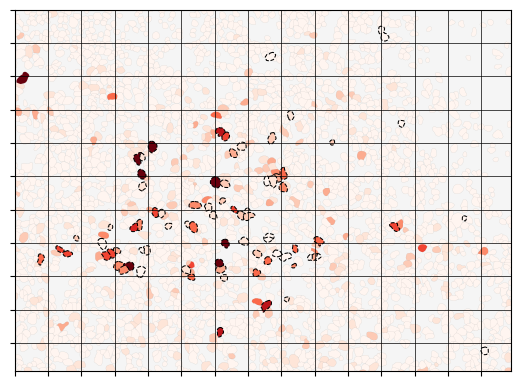

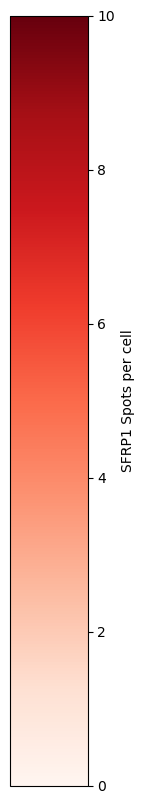

In [138]:
# gene_of_interest = 'VCAM1'
gene_of_interest = 'SFRP1'
# gene_of_interest = 'SPARC'
# gene_of_interest = 'SFRP1'
# gene_of_interest = 'FN1'
# gene_of_interest = 'BGN'
cluster_of_interest = 31

# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)

cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)

central_ix = int(len(cluster_cells)/2)

cell_id = cluster_cells[central_ix]

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

# sg_obj.gdf['object_id'] = sg_obj.gdf.index
# sg_obj.gdf['cell_id'] = sg_obj.gdf['cell_id'].astype('string')


gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')


fig,ax = plt.subplots()
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SFRP1'],central_polygon_ix=central_ix,
                            color_map={'SFRP1':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                            #    id_field='cell_id',
                            annotate=False,image_scale=0.1,
                            focal_outline_color='r',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.2,
                            exterior_marker='.',marker_size=5,ax=ax)

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

plt.axis('off')
# plt.title()
plt.gca().invert_yaxis()

### PLOT THE ZOOMED IN IMAGE     
fig,ax = plt.subplots()

vmin = 0
vmax = 10

bbox = box(xmin,ymin,xmax,ymax)

other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

# other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

# print(merged_gdf_focal.shape)

merged_gdf_other.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

# this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]
this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='k',linewidth=0.75,linestyle='--')

# rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
# ax.add_patch(rect)

# ax.set_xticks([])
# ax.set_yticks([])
ax.set_facecolor('#F5F5F5')

# visium HD has 2 micron grid size. This is roughly every 2000/107 = 18.7 pixels
# plt.gca().set_xticks([xmin+18.7*i for i in range(int((xmax-xmin)/18.7)+1)])
# plt.gca().set_yticks([ymin+18.7*i for i in range(int((ymax-ymin)/18.7)+1)])
# plt.gca().tick_params(which='major', color='k')
# plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.1)

# visium HD has 8 micron grid size as starting point. This is roughly every 8000/107 =74.77 pixels
# plt.gca().set_xticks([xmin+74.77*i for i in range(int((xmax-xmin)/74.77)+1)])
# plt.gca().set_yticks([ymin+74.77*i for i in range(int((ymax-ymin)/74.77)+1)])
# plt.gca().tick_params(which='major', color='k')
# plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.1)

# visium has 55 micron grid size. This is roughly every 55000/107 = 514 pixels
plt.gca().set_xticks(xedges)
plt.gca().set_yticks(yedges)
plt.gca().tick_params(which='major', color='k')
plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.5)

plt.gca().xaxis.set_ticklabels([])
plt.gca().yaxis.set_ticklabels([])

ax.tick_params(axis='both', which='major', labelsize=5)
ax.tick_params(axis='both', which='minor', labelsize=2)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()

# plt.axis('off')

plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_zoom_VisiumGrid.pdf',bbox_inches='tight')


# ### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
# fig,ax = plt.subplots()

# # ax = fig.add_subplot(223)

# merged_gdf.plot(column=gene_of_interest, cmap='Reds', legend=False,vmin=vmin,vmax=vmax,ax=ax,
#                 edgecolor='#d9d9d9',linewidth=0.01)


# # ax.set_facecolor('k')
# rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
# # Add the patch to the Axes
# ax.add_patch(rect)

# # ax.set_facecolor('#F5F5F5')
# # ax.set_xticks([])
# # ax.set_yticks([])

# plt.gca().invert_yaxis()

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_full.pdf',bbox_inches='tight')


### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(1,10))
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')



In [86]:
xedges

array([ 9078.10286042,  9592.10286042, 10106.10286042, 10620.10286042,
       11134.10286042, 11648.10286042, 12162.10286042, 12676.10286042,
       13190.10286042, 13704.10286042, 14218.10286042, 14732.10286042,
       15246.10286042, 15760.10286042, 16274.10286042])

16731.892123714435

In [98]:
int((xmax-xmin)/bin_size)+1

15

In [101]:
xmin

9078.102860415765

In [100]:
xmax

16731.892123714435

In [103]:
n_y_bins

11

20.0
PearsonRResult(statistic=0.01836724574793656, pvalue=0.11057759008174804)
31.0
PearsonRResult(statistic=0.5253586097377524, pvalue=0.0)
72.0
PearsonRResult(statistic=-0.041863799773654634, pvalue=0.0002746706374749035)
165.0
PearsonRResult(statistic=0.0050719820487436845, pvalue=0.6595172795066779)
196.0
PearsonRResult(statistic=0.0051034808547835535, pvalue=0.6575372404849831)
211.0
PearsonRResult(statistic=0.007482039511913844, pvalue=0.5157340515565726)
324.0
PearsonRResult(statistic=0.012166382336784442, pvalue=0.29057094999452865)
360.0
PearsonRResult(statistic=-0.00701062629466149, pvalue=0.5425347806805877)
539.0
PearsonRResult(statistic=0.013761820886248433, pvalue=0.231901520578326)
648.0
PearsonRResult(statistic=-0.014028099035435466, pvalue=0.22299282102260695)
919.0
PearsonRResult(statistic=0.02164754596804876, pvalue=0.06002214239236511)


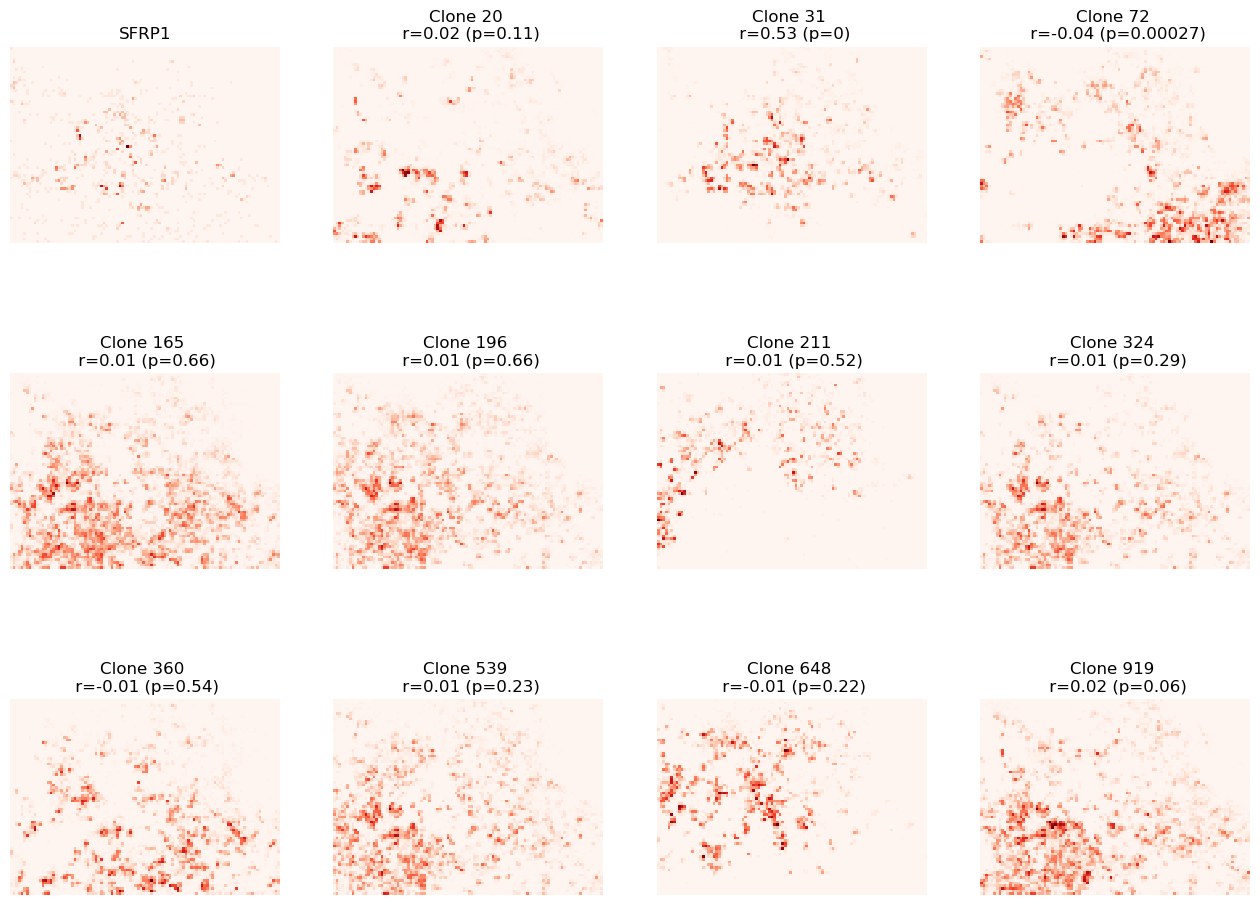

In [139]:
clusters,counts = np.unique(region['bc_cluster'],return_counts=True)

# get the clusters with at least 10 cells
clusters = clusters[counts>=10]
# drop na
clusters = clusters[~np.isnan(clusters)]

plt.figure(figsize=(4*4,4*3))
plt.subplot(3,4,1)
points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name']=='SFRP1']

# bin_size = 514 # visium bin size
bin_size = 74.77 # visiumHD bin size

n_x_bins = int((xmax-xmin)/bin_size)+1
n_y_bins = int((ymax-ymin)/bin_size)+1

H_gene, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(n_x_bins)],
                                                                   [ymin+bin_size*i for i in range(n_y_bins)]],
                                                                   range=[[xmin,xmin+bin_size*n_x_bins],[ymin,ymin+bin_size*n_x_bins]])

# Plot the 2D histogram
plt.imshow(H_gene.swapaxes(0,1), interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Reds')
# plt.colorbar()
# plt.gca().set_aspect('equal')
# plt.gca().set_aspect(abs((xedges[-1]-xedges[0])/(yedges[0]-yedges[-1]))*1)
plt.gca().invert_yaxis()
plt.title('SFRP1')

# plt.gca().set_xticks(xedges)
# plt.gca().set_yticks(yedges)
# plt.gca().tick_params(which='major', color='k')
# plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.5)

# plt.xticks()
plt.axis('off')
# plt.show()

for c,cluster in enumerate(clusters):

    this_name = region[region['bc_cluster']==cluster]['bc_cluster_bc_names'].values[0]
    cluster_barcodes = this_name.split('-')

    points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name'].isin(cluster_barcodes)]

    H, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+bin_size*i for i in range(int((xmax-xmin)/bin_size)+1)],
                                                                   [ymin+bin_size*i for i in range(int((ymax-ymin)/bin_size)+1)]],
                                                                   range=[[xmin,xmax],[ymin,ymax]])
    
    print(cluster)
    print(scipy.stats.pearsonr(H_gene.flatten(),H.flatten()))

    plt.subplot(3,4,c+2)

    # Plot the 2D histogram
    plt.imshow(H.swapaxes(0,1), interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Reds')
    # plt.colorbar()
    # plt.gca().set_aspect('equal')
    # plt.gca().set_aspect(abs((xedges[-1]-xedges[0])/(yedges[0]-yedges[-1]))*1)
    plt.gca().invert_yaxis()
    plt.title(f'Clone {int(cluster)} \n r={scipy.stats.pearsonr(H_gene.flatten(),H.flatten())[0]:.2f} (p={scipy.stats.pearsonr(H_gene.flatten(),H.flatten())[1]:.2g})')
    plt.axis('off')

# plt.savefig('plots/figures/forpaper_cluster_31_SFRP1_spots_visiumcomparision.pdf',bbox_inches='tight')
plt.savefig('plots/figures/forpaper_cluster_31_SFRP1_spots_visiumHDcomparision.pdf',bbox_inches='tight')

In [125]:
H

array([[7.400e+01, 2.800e+01, 2.000e+00, 3.200e+01, 5.100e+01, 1.570e+02,
        4.240e+02, 5.480e+02, 2.420e+02, 4.100e+02],
       [5.000e+01, 1.900e+02, 1.320e+02, 2.490e+02, 1.900e+02, 4.450e+02,
        6.650e+02, 8.330e+02, 5.620e+02, 7.200e+02],
       [7.000e+00, 1.410e+02, 1.250e+02, 1.920e+02, 3.430e+02, 8.180e+02,
        1.000e+03, 1.038e+03, 7.850e+02, 9.770e+02],
       [3.000e+00, 6.300e+01, 4.000e+02, 2.050e+02, 1.790e+02, 3.510e+02,
        9.610e+02, 1.206e+03, 5.500e+02, 9.320e+02],
       [3.000e+00, 1.600e+01, 2.090e+02, 1.770e+02, 1.140e+02, 2.030e+02,
        9.760e+02, 1.164e+03, 9.810e+02, 1.170e+03],
       [6.000e+00, 1.100e+01, 1.030e+02, 1.230e+02, 2.400e+01, 1.170e+02,
        4.350e+02, 8.340e+02, 7.270e+02, 1.254e+03],
       [7.200e+01, 5.300e+01, 1.630e+02, 2.470e+02, 1.300e+02, 1.220e+02,
        1.220e+02, 3.310e+02, 8.280e+02, 4.680e+02],
       [2.300e+01, 1.130e+02, 2.110e+02, 3.100e+01, 8.700e+01, 1.880e+02,
        4.360e+02, 5.120e+02, 3.220e+

In [108]:
region[region['bc_cluster']==648]

,nucleus,nucleus_dilated,nucleus_centroid,center_x,center_y,area,object_id,cell_id,AKT1,AXL,...,bc_093,bc_094,bc_095,bc_096,bc_cluster,bc_cluster_bc_names,bc_cluster_found_bcs,bc_cluster_n_bcs,called_barcodes,n_called_barcodes
22118,"POLYGON ((10709.000 22636.000, 10711.000 22636...","POLYGON ((10702.384 22628.502, 10685.384 22643...",POINT (10718.773 22709.861),10718.773223,22709.860814,12488.881512,29905,29905,1.0,0.0,...,0.0,0.0,0.0,0.0,648.0,bc_009,['bc_009'],1.0,"['bc_004', 'bc_009', 'bc_024', 'bc_048']",4
22151,"POLYGON ((9276.000 22656.000, 9293.000 22656.0...","POLYGON ((9271.862 22646.896, 9249.862 22656.8...",POINT (9259.308 22721.217),9259.307680,22721.217258,13841.014541,29935,29935,5.0,0.0,...,0.0,0.0,0.0,0.0,648.0,bc_009,['bc_009'],1.0,['bc_009'],1
22366,"POLYGON ((10687.000 22779.000, 10721.000 22785...","POLYGON ((10684.253 22769.385, 10677.253 22771...",POINT (10746.638 22816.833),10746.637818,22816.833179,10108.491085,30127,30127,1.0,0.0,...,0.0,0.0,0.0,0.0,648.0,bc_009,['bc_009'],1.0,"['bc_009', 'bc_024', 'bc_031', 'bc_087']",4
22788,"POLYGON ((9558.000 23007.000, 9574.000 23009.0...","POLYGON ((9554.286 22997.715, 9546.681 23000.7...",POINT (9572.092 23052.746),9572.091793,23052.745543,8459.403033,30507,30507,4.0,1.0,...,0.0,0.0,0.0,0.0,648.0,bc_009,['bc_009'],1.0,"['bc_009', 'bc_022']",2
22809,"POLYGON ((10339.000 23021.000, 10350.000 23023...","POLYGON ((10335.838 23011.513, 10329.838 23013...",POINT (10365.422 23083.713),10365.422073,23083.713162,11865.891918,30526,30526,1.0,0.0,...,0.0,0.0,0.0,0.0,648.0,bc_009,['bc_009'],1.0,"['bc_009', 'bc_024']",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27228,"POLYGON ((10477.000 25414.000, 10491.000 25415...","POLYGON ((10473.838 25404.513, 10455.838 25410...",POINT (10532.903 25493.947),10532.903181,25493.947111,18974.822803,34503,34503,10.0,0.0,...,0.0,0.0,0.0,0.0,648.0,bc_009,['bc_009'],1.0,"['bc_009', 'bc_048', 'bc_060']",3
27449,"POLYGON ((10830.000 25534.000, 10847.000 25536...","POLYGON ((10828.157 25524.171, 10796.157 25530...",POINT (10822.100 25594.905),10822.100233,25594.904808,14959.008695,34702,34702,7.0,0.0,...,0.0,0.0,0.0,0.0,648.0,bc_009,['bc_009'],1.0,"['bc_009', 'bc_024']",2
27591,"POLYGON ((10739.000 25613.000, 10771.000 25615...","POLYGON ((10733.855 25604.425, 10723.855 25610...",POINT (10763.640 25647.725),10763.639869,25647.724833,7138.800148,34830,34830,1.0,0.0,...,0.0,0.0,0.0,0.0,648.0,bc_009,['bc_009'],1.0,['bc_009'],1
27926,"POLYGON ((10569.000 25794.000, 10593.000 25796...","POLYGON ((10566.017 25784.455, 10550.017 25789...",POINT (10579.911 25837.984),10579.911334,25837.983798,9504.092422,35131,35131,8.0,0.0,...,0.0,0.0,0.0,0.0,648.0,bc_009,['bc_009'],1.0,['bc_009'],1


Text(0.5, 1.0, 'Clone 31 spots')

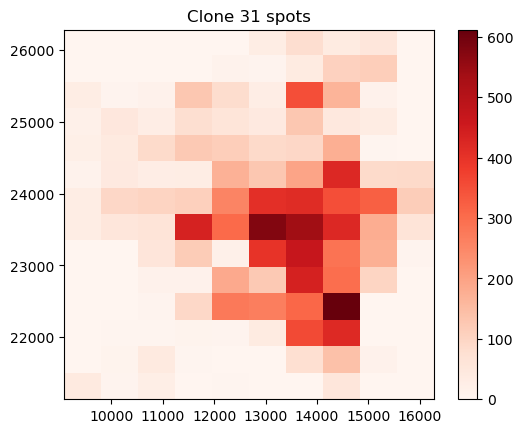

In [64]:
cluster_bc_name = 'bc_016-bc_040-bc_052-bc_092-bc_093'

cluster_barcodes = cluster_bc_name.split('-')

points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name'].isin(cluster_barcodes)]

H, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+514*i for i in range(int((xmax-xmin)/514)+1)],
                                                                [ymin+514*i for i in range(int((ymax-ymin)/514)+1)]])
plt.figure()

# Plot the 2D histogram
plt.imshow(H, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Reds')
plt.colorbar()
# plt.gca().set_aspect('equal')
plt.gca().set_aspect(abs((xedges[-1]-xedges[0])/(yedges[0]-yedges[-1]))*1)
plt.title('Clone 31 spots')
# plt.show()

In [122]:
max(sg_obj.points_gdf[sg_obj.points_gdf['name']=='SFRP1'].x)

56372

In [ ]:
max(sg_obj.points_gdf[sg_obj.points_gdf['name']=='SFRP1'].x)

In [ ]:
np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+514*i for i in range(int((xmax-xmin)/514)+1)],
                                                                    [ymin+514*i for i in range(int((ymax-ymin)/514)+1)]])

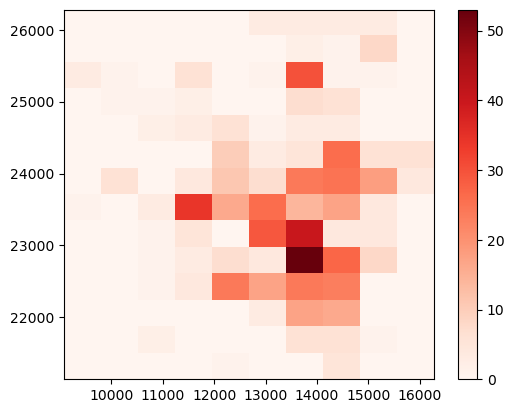

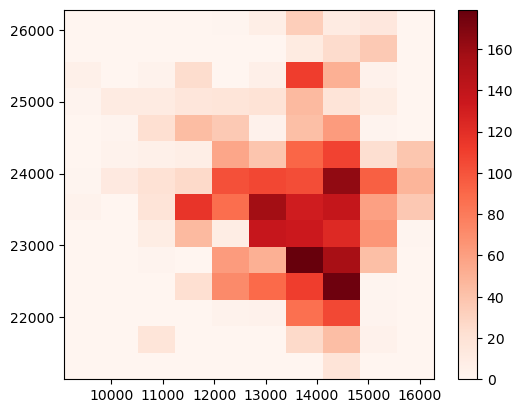

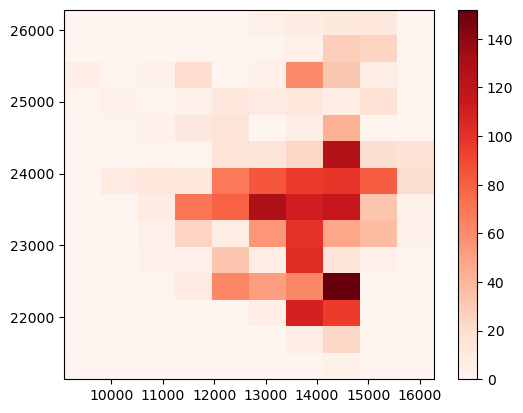

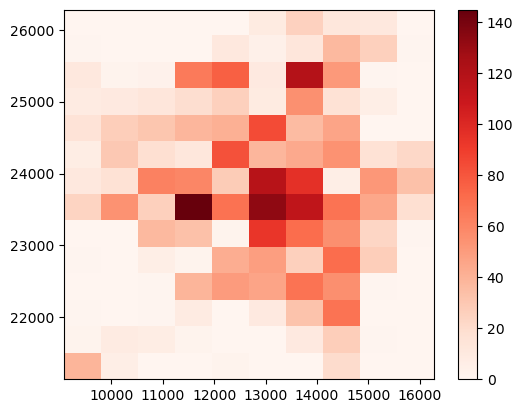

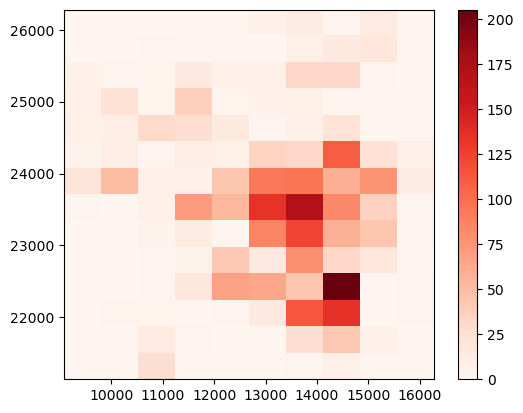

In [62]:
cluster_bc_name = 'bc_016-bc_040-bc_052-bc_092-bc_093'

cluster_barcodes = cluster_bc_name.split('-')

for bc in cluster_barcodes:
    points_of_interest = sg_obj.points_gdf[sg_obj.points_gdf['name']==bc]

    H, xedges, yedges = np.histogram2d(x=points_of_interest.x,y=points_of_interest.y,bins=[[xmin+514*i for i in range(int((xmax-xmin)/514)+1)],
                                                                    [ymin+514*i for i in range(int((ymax-ymin)/514)+1)]])
    plt.figure()

    # Plot the 2D histogram
    plt.imshow(H, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Reds')
    plt.colorbar()
    # plt.gca().set_aspect('equal')
    plt.gca().set_aspect(abs((xedges[-1]-xedges[0])/(yedges[0]-yedges[-1]))*1)
    # plt.show()

In [ ]:
barcodes_of_interest = sg_obj.gdf[sg_obj.gdf['cell_id'].isin(cluster_cells)]

,name,refid,x,y,geometry
1728864,SFRP1,ENSG00000104332,19490,1460,POINT (19490.000 1460.000)
1728865,SFRP1,ENSG00000104332,15255,1745,POINT (15255.000 1745.000)
1728866,SFRP1,ENSG00000104332,19129,1749,POINT (19129.000 1749.000)
1728867,SFRP1,ENSG00000104332,19427,1536,POINT (19427.000 1536.000)
1728868,SFRP1,ENSG00000104332,19271,1751,POINT (19271.000 1751.000)
...,...,...,...,...,...
1739598,SFRP1,ENSG00000104332,26899,45315,POINT (26899.000 45315.000)
1739599,SFRP1,ENSG00000104332,28535,45460,POINT (28535.000 45460.000)
1739600,SFRP1,ENSG00000104332,36051,45369,POINT (36051.000 45369.000)
1739601,SFRP1,ENSG00000104332,40244,45334,POINT (40244.000 45334.000)


In [117]:
clusters

array([ 20.,  31.,  72., 165., 196., 211., 324., 360., 539., 648., 919.])

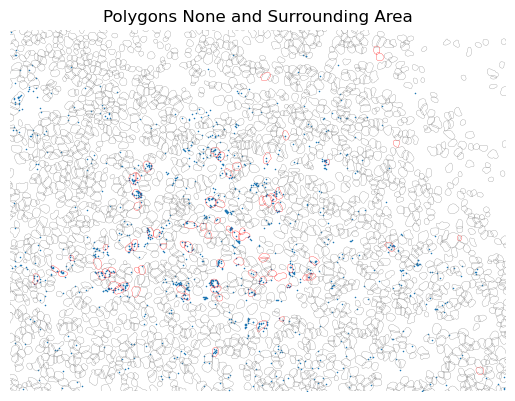

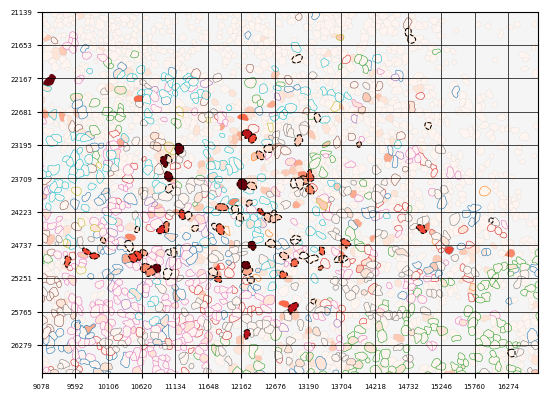

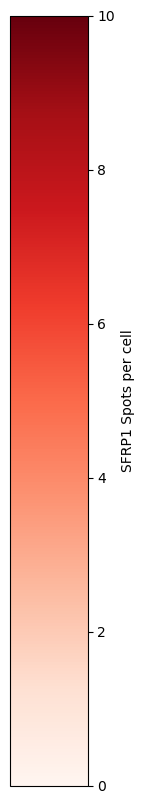

In [119]:
# gene_of_interest = 'VCAM1'
gene_of_interest = 'SFRP1'
# gene_of_interest = 'SPARC'
# gene_of_interest = 'SFRP1'
# gene_of_interest = 'FN1'
# gene_of_interest = 'BGN'
# cluster_of_interest = 31
# cluster_of_interest = 648

clusters_of_interest = clusters

# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest].obs['cell_id'].values)

cluster_cells = list(adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])].obs['cell_id'].values)

central_ix = int(len(cluster_cells)/2)

cell_id = cluster_cells[central_ix]

region = tools.get_polygons_around_polygon(sg_obj,cell_id,image_scale=25,id_field='cell_id')

# sg_obj.gdf['object_id'] = sg_obj.gdf.index
# sg_obj.gdf['cell_id'] = sg_obj.gdf['cell_id'].astype('string')


gene_names = tools.get_all_barcodes_in_region(df,region['cell_id'].values,id_field='cell_id')


fig,ax = plt.subplots()
tools.plot_polygons_and_points(sg_obj,cluster_cells,gene_names=['SFRP1'],central_polygon_ix=central_ix,
                            color_map={'SFRP1':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)},
                            #    id_field='cell_id',
                            annotate=False,image_scale=0.1,
                            focal_outline_color='r',other_outline_color='gray',
                            interior_marker='.',single_mode=False,lw=0.2,
                            exterior_marker='.',marker_size=5,ax=ax)

ymin,ymax = plt.ylim()
xmin,xmax = plt.xlim()

plt.axis('off')
# plt.title()
plt.gca().invert_yaxis()

### PLOT THE ZOOMED IN IMAGE     
fig,ax = plt.subplots()

vmin = 0
vmax = 10

bbox = box(xmin,ymin,xmax,ymax)

other_clusters = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (~sg_obj.gdf['cell_id'].isin(cluster_cells)) & (~sg_obj.gdf['bc_cluster'].isin(clusters_of_interest))]

merged_gdf_other = merged_gdf[merged_gdf['cell_id'].isin(other_clusters['cell_id'].values)]

merged_gdf_other.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='gray',linewidth=0.05)

for c,cluster_of_interest in enumerate(clusters_of_interest):
    cluster_of_interest_subset = sg_obj.gdf[sg_obj.gdf.geometry.intersects(bbox) & (sg_obj.gdf['bc_cluster'].isin([cluster_of_interest]))]

    merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(cluster_of_interest_subset['cell_id'].values)]

    merged_gdf_focal.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                    vmin=vmin,vmax=vmax,edgecolor=sns.color_palette()[c%10],linewidth=0.4,linestyle='-')

# this_cluster = adata_genes[adata_genes.obs['bc_cluster']==cluster_of_interest]

## MANUAL CLUSTER 31
this_cluster = adata_genes[adata_genes.obs['object_id'].isin(manual_cluster['object_id'])]

merged_gdf_focal = merged_gdf[merged_gdf['cell_id'].isin(this_cluster.obs['cell_id'].values)]

# print(merged_gdf_focal.shape)
merged_gdf_focal.plot(column=gene_of_interest, cmap='Reds', legend=False, ax=ax,
                vmin=vmin,vmax=vmax,edgecolor='k',linewidth=0.75,linestyle='--')

# rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
# ax.add_patch(rect)

# ax.set_xticks([])
# ax.set_yticks([])
ax.set_facecolor('#F5F5F5')

# visium HD has 2 micron grid size. This is roughly every 2000/107 = 18.7 pixels
# plt.gca().set_xticks([xmin+18.7*i for i in range(int((xmax-xmin)/18.7)+1)])
# plt.gca().set_yticks([ymin+18.7*i for i in range(int((ymax-ymin)/18.7)+1)])
# plt.gca().tick_params(which='major', color='k')
# plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.1)

# visium HD has 8 micron grid size as starting point. This is roughly every 8000/107 =74.77 pixels
# plt.gca().set_xticks([xmin+74.77*i for i in range(int((xmax-xmin)/74.77)+1)])
# plt.gca().set_yticks([ymin+74.77*i for i in range(int((ymax-ymin)/74.77)+1)])
# plt.gca().tick_params(which='major', color='k')
# plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.1)

# visium has 55 micron grid size. This is roughly every 55000/107 = 514 pixels
plt.gca().set_xticks(xedges)
plt.gca().set_yticks(yedges)
plt.gca().tick_params(which='major', color='k')
plt.gca().grid(True, which='major',zorder=100,color='k',lw=0.5)

# plt.gca().xaxis.set_ticklabels([])
# plt.gca().yaxis.set_ticklabels([])

ax.tick_params(axis='both', which='major', labelsize=5)
ax.tick_params(axis='both', which='minor', labelsize=2)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()


plt.savefig(f'plots/figures/forpaper_cluster_31_SFRP1_zoom_VisiumGrid_allbigclusters.pdf',bbox_inches='tight')


# ### PLOT THE FULL IMAGE WITH THE CLUSTER HIGHLIGHTED
# fig,ax = plt.subplots()

# # ax = fig.add_subplot(223)

# merged_gdf.plot(column=gene_of_interest, cmap='Reds', legend=False,vmin=vmin,vmax=vmax,ax=ax,
#                 edgecolor='#d9d9d9',linewidth=0.01)


# # ax.set_facecolor('k')
# rect = matplotlib.patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=0.5, edgecolor='k', facecolor='none')
# # Add the patch to the Axes
# ax.add_patch(rect)

# # ax.set_facecolor('#F5F5F5')
# # ax.set_xticks([])
# # ax.set_yticks([])
# plt.axis('off')
# plt.gca().invert_yaxis()

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_full.pdf',bbox_inches='tight')


### PLOT THE COLORBAR
fig,ax = plt.subplots(figsize=(1,10))
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap='Reds',
                            norm=norm,
                            orientation='vertical')
cb1.set_label('SFRP1 Spots per cell')

# plt.savefig(f'plots/figures/forpaper_cluster_{cluster_of_interest}_SFRP1_cb.pdf',bbox_inches='tight')

